This kernel will help beginners to make themselves familiar with the Time Series Analysis in Python. Kernel includes all the essential things required for a beginner to start with time series. Let's begin!

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

In [4]:
data = pd.read_csv('AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
data.dtypes

Month          object
#Passengers     int64
dtype: object

In [6]:
#Convert Month object into datetime
data['Month'] = pd.to_datetime(data.Month)
data = data.set_index(data.Month)
data.drop('Month', axis = 1, inplace = True)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [9]:
ts = data['#Passengers']
ts

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: #Passengers, Length: 144, dtype: int64

In [10]:
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

### 1. Check for Stationarity of Time Series

A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time and an autocovariance that does not depend on time.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


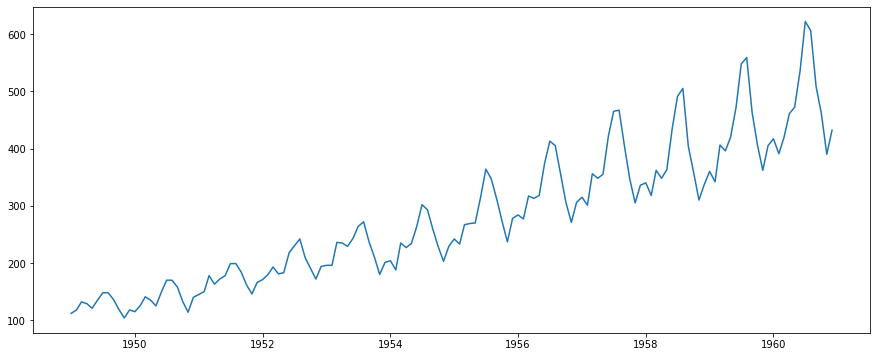

In [11]:
rcParams['figure.figsize'] = 15,6
plt.plot(ts)

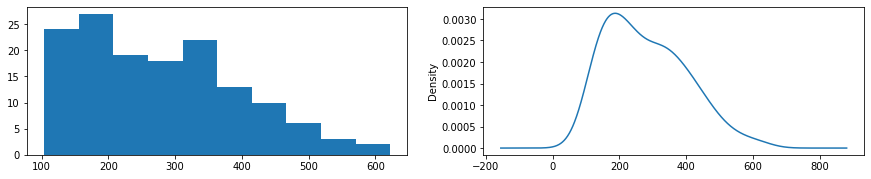

In [8]:
plt.subplot(221)
plt.hist(ts)
plt.subplot(222)
ts.plot(kind = 'kde')

We’ll be using the rolling statistics plots along with Dickey-Fuller test results a lot so I have defined a function which takes a TS as input and generated them for us. Please note that I’ve plotted standard deviation instead of variance to keep the unit similar to mean.

In [9]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determining rolling statistics
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()
    
    #plotting rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    st = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling  Mean & Standard Deviation')
    plt.show()
    
    #Dickey_Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

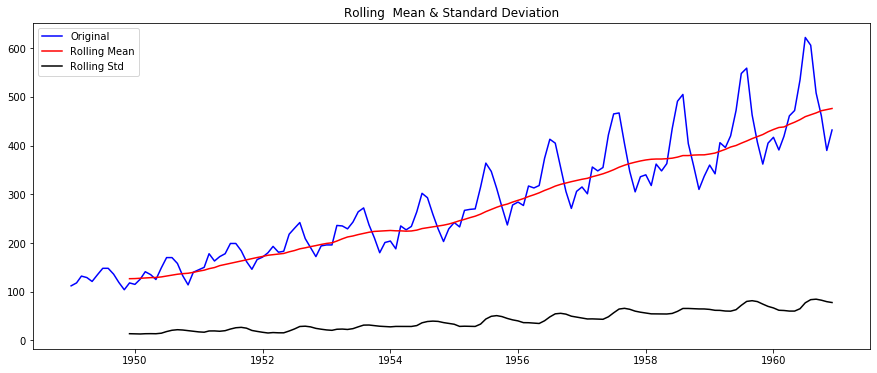

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [10]:
test_stationarity(ts)

Standard deviation has very less variation but mean is increasing continously. Hence, it's not a stationary series. Also, the test statistic is way more than the critical values (compare signed values and not the absolute values).

### 2. Make the Series Stationary

Its almost impossible to make a series perfectly stationary, but we try to take it as close as possible.

Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationaruty of a TS:
1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

#### Estimating & Eliminating Trend

We can clearly see that the there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity.

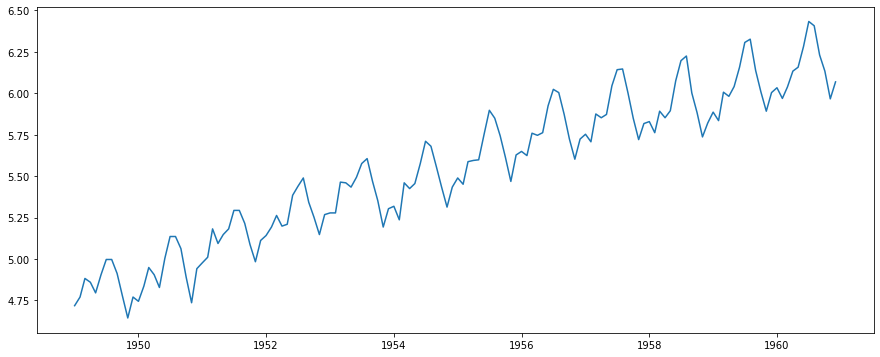

In [11]:
#let's take a log transform for simplicity:
ts_log = np.log(ts)
plt.plot(ts_log)

In this simpler case, it is easy to see a forward trend in the data. But its not very intuitive in presence of noise. So we can use some techniques to estimate or model this trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:

 1. Aggregation – taking average for a time period like monthly/weekly averages
 2. Smoothing – taking rolling averages
 3. Polynomial Fitting – fit a regression model
 
 We will apply smoothing here.

#### Moving average

In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values. Pandas has specific functions defined for determining rolling statistics.

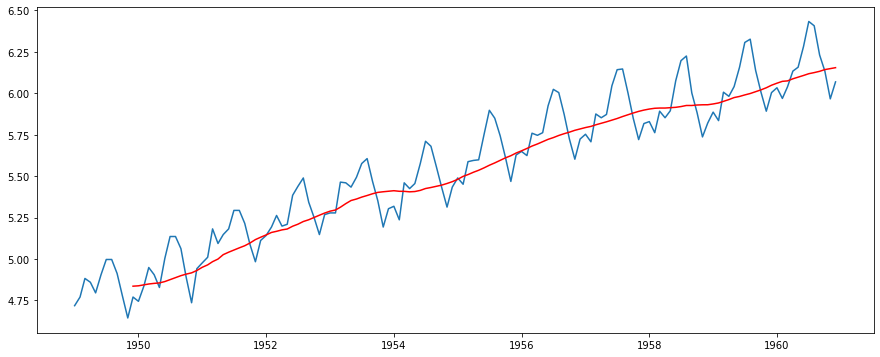

In [12]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color = 'red')

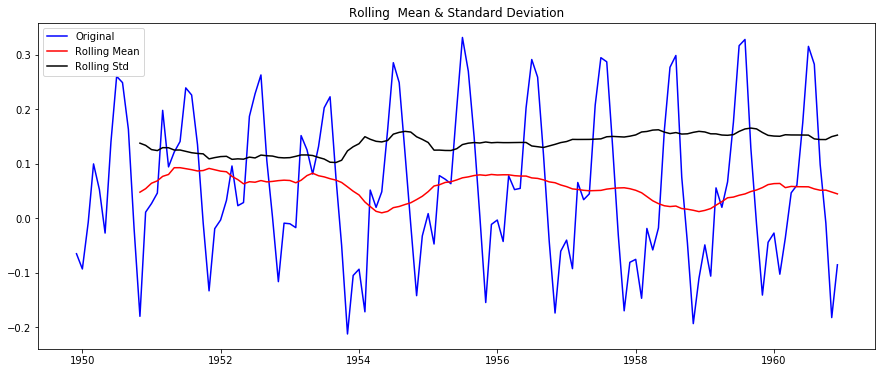

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [13]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(ts_log_moving_avg_diff)

The rolling values appear to be varying slightly but there is no specific trend. Also, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series. However, a drawback in this particular approach is that the time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. So we take a ‘weighted moving average’ where more recent values are given a higher weight. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor. 

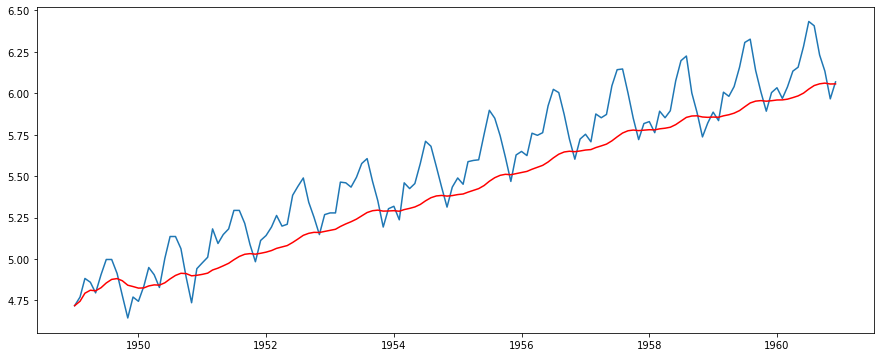

In [14]:
exp_weighted_avg = ts_log.ewm(halflife = 12).mean()
plt.plot(ts_log)
plt.plot(exp_weighted_avg, color = 'red')

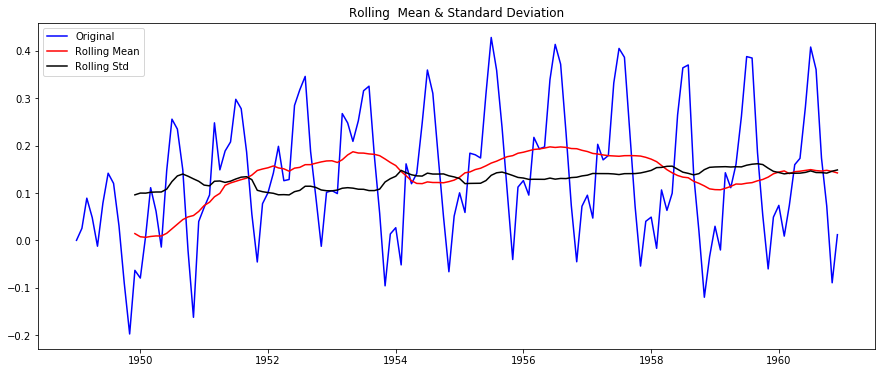

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [15]:
ts_log_ema_diff = ts_log - exp_weighted_avg
test_stationarity(ts_log_ema_diff)

This TS has even lesser variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the 1% critical value, which is better than the previous case.

### 3. Eliminating Trend and Seasonality

Two methods:
 1. Differencing (taking the differece with a particular time lag)
 2. Decomposition (modeling both trend and seasonality and removing them from the model)

#### Differencing

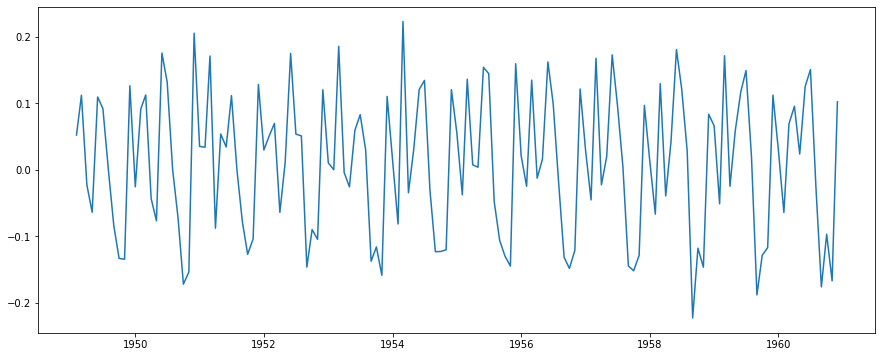

In [16]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
#ts_log.diff().plot()

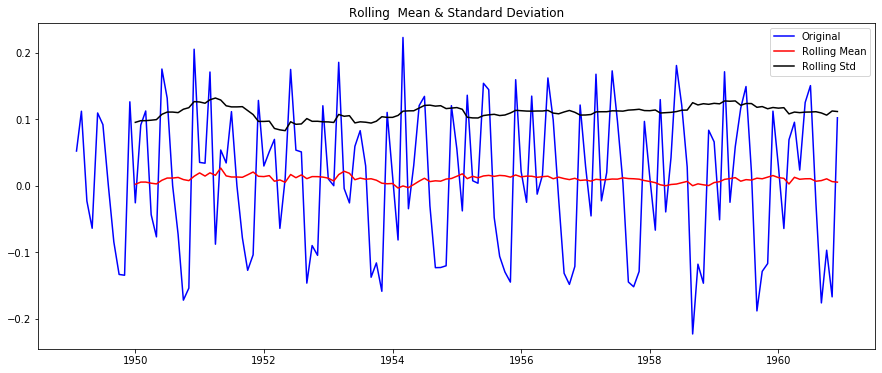

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [17]:
ts_log_diff.dropna(inplace = True)
test_stationarity(ts_log_diff)

We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence. We can also take second or third order differences which might get even better results in certain applications.

#### Decomposing

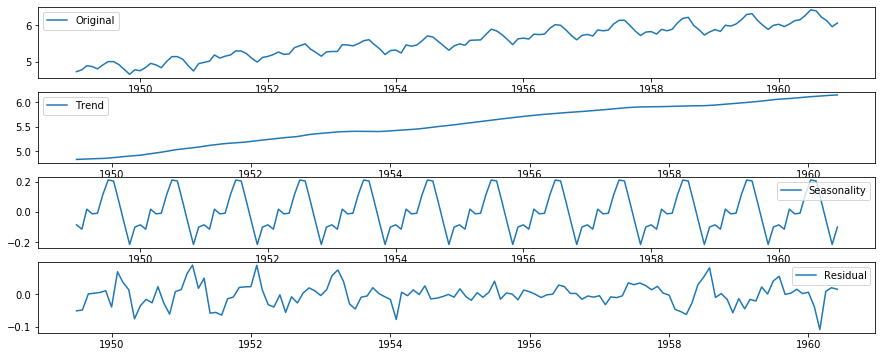

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')

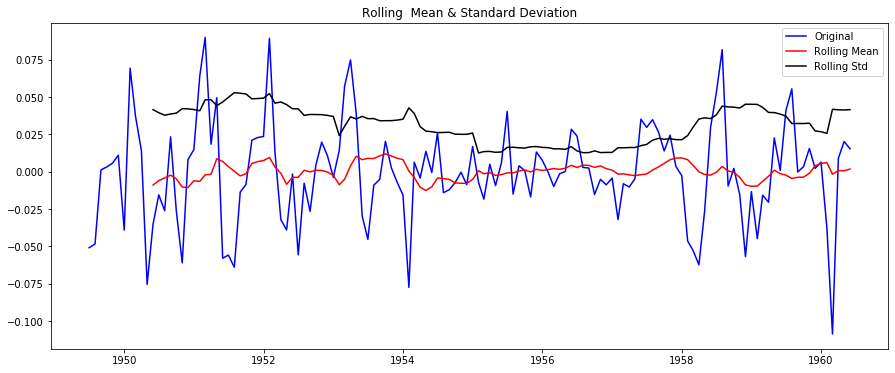

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [19]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace = True)
test_stationarity(ts_log_decompose)

The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary.

### 4. Forecasting a Time Series

Lets make model on the TS after differencing as it is a very popular technique. Also, its relatively easier to add noise and seasonality back into predicted residuals in this case. Having performed the trend and seasonality estimation techniques, there can be two situations: 1. A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare. 2. A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.

The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

1.Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

2.Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

3.Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers.

1.Autocorrelation Function (ACF): It is a measure of the correlation between the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).

2.Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

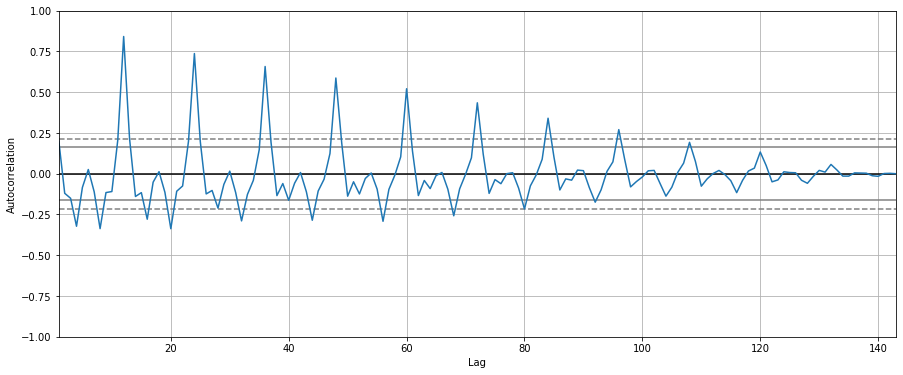

In [20]:
#ACF plot
pd.plotting.autocorrelation_plot(ts_log_diff)

Due to seasonality, at lag 12 autocorrelation is high and for every multiple of 12, autocorrelation will be high but will keep decreasing moving further.

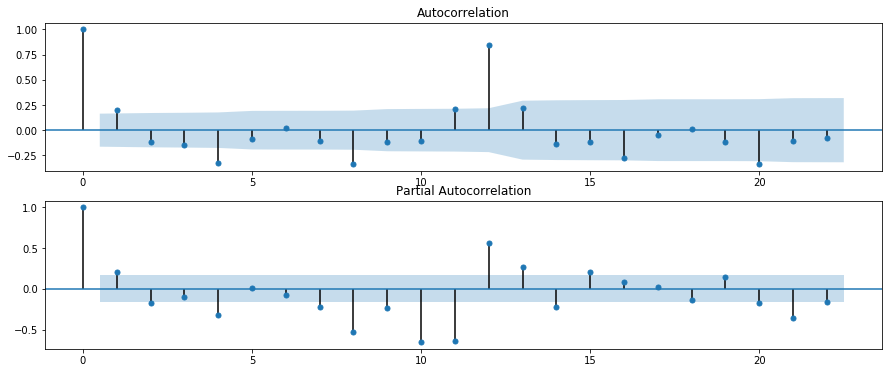

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.subplot(211)
plot_acf(ts_log_diff, ax=plt.gca())
plt.subplot(212)
plot_pacf(ts_log_diff, ax=plt.gca())
plt.show()

In [22]:
#Another method
#ACF and PACF plots
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


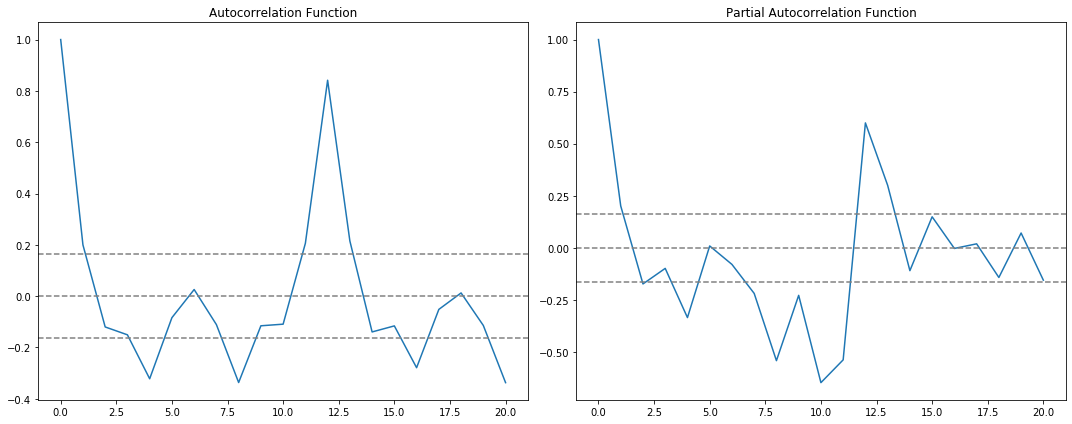

In [23]:
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray') #Add a horizontal line across the axis at y = 0.
plt.axhline(y = -1.96/np.sqrt(len(ts_log_diff)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(ts_log_diff)), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color = 'gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout() #Automatically adjust subplot parameters to give specified padding.

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time (p=2).

q – The lag value where the ACF chart crosses the upper confidence interval for the first time(q=2).

Now, lets make 3 different ARIMA models considering individual as well as combined effects. We will also print the RSS for each. Please note that here RSS is for the values of residuals and not actual series.

We need to load the ARIMA model first:

In [24]:
from statsmodels.tsa.arima_model import ARIMA, ARMAResults

#### AR Model

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.5023')

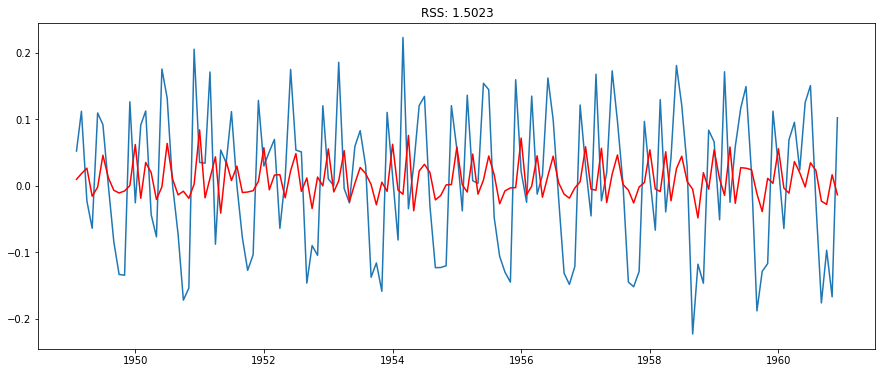

In [25]:
model = ARIMA(ts_log, order = (2,1,0))
results_AR = model.fit(disp = -1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - ts_log_diff)**2)) #Residual sum of squares

#### MA Model

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.4721')

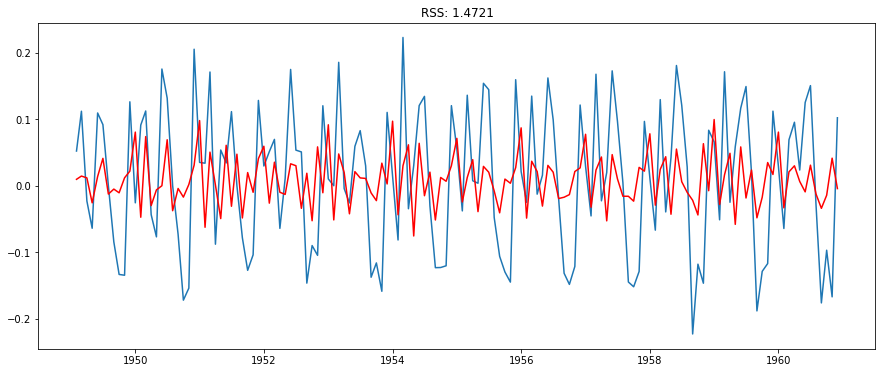

In [26]:
model = ARIMA(ts_log, order= (0, 1, 2))  
results_MA = model.fit(disp = -1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color= 'red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues - ts_log_diff)**2))

#### Combined Model

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.0292')

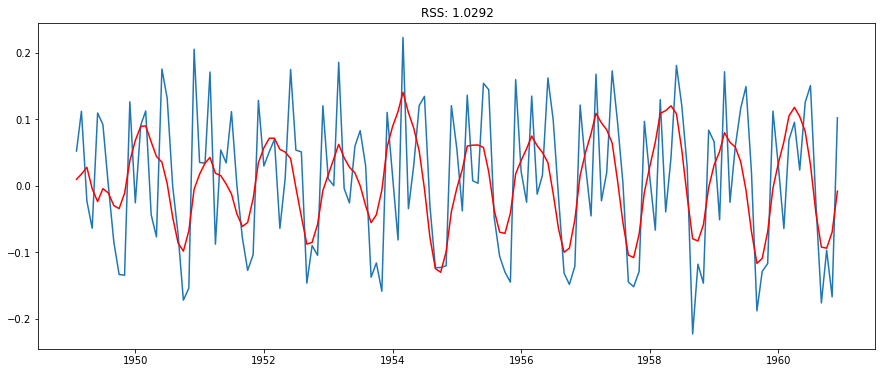

In [27]:
model = ARIMA(ts_log, order = (2, 1, 2))  
results_ARIMA = model.fit(disp = -1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color= 'red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues - ts_log_diff)**2))

Here we can see that the AR and MA models have almost the same RSS but combined is significantly better. 

#### Taking it back to original scale

In [28]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [29]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [30]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Text(0.5, 1.0, 'RMSE: 90.1044')

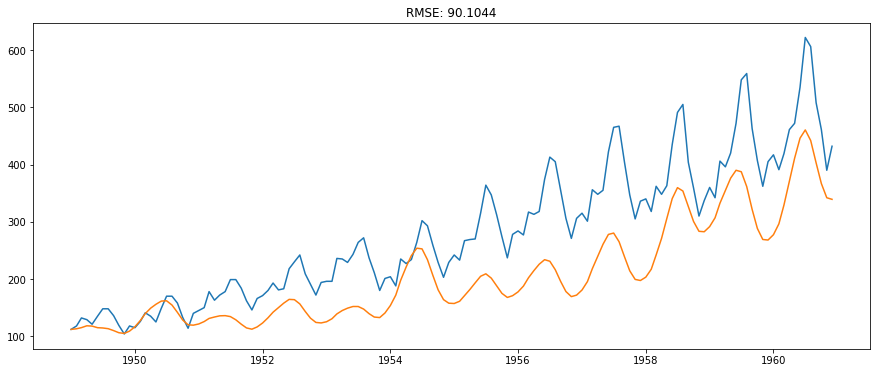

In [31]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

This predicton is not that much good as it should be and root mean square error is also very high.

# Another method (using SARIMAX)

### 1. Parameter Selection for the ARIMA Time Series Model

In [32]:
import itertools
p = d = q = range(2)
pdq = list(itertools.product(p, d, q))      #Generate all different combinations of p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]       #Generate all different combinations of seasonal p, q and q triplet

We can now use the triplets of parameters defined above to automate the process of training and evaluating ARIMA models on different combinations. In Statistics and Machine Learning, this process is known as grid search (or hyperparameter optimization) for model selection.

In [33]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")           #Specify to ignore warning messages
AIC_df = pd.DataFrame({}, columns = ['param', 'param_seasonal', 'AIC'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_log, order = param, seasonal_order = param_seasonal, enforce_stationarity = False, enforce_invertibility = False)
            results = mod.fit()
            #print('ARIMA{}x{}-AIC:{}'.format(param, param_seasonal, results.aic))
            temp = pd.DataFrame([[param, param_seasonal, results.aic]], columns = ['param', 'param_seasonal', 'AIC'])
            AIC_df = AIC_df.append(temp, ignore_index = True)
            del temp
        except:
            continue

### 2. Fitting an ARIMA Time Series Model

In [34]:
min_aic = AIC_df.sort_values(by = 'AIC').iloc[0]    #Row with minimum AIC value
model = sm.tsa.statespace.SARIMAX(ts_log, order = min_aic.param, seasonal_order = min_aic.param_seasonal, enforce_stationarity = False, enforce_invertibility = False)
results = model.fit()
#print(results.summary())
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9419      0.039     24.105      0.000       0.865       1.019
ma.L1         -0.3804      0.093     -4.093      0.000      -0.563      -0.198
ar.S.L12       1.0200      0.003    302.398      0.000       1.013       1.027
ma.S.L12      -0.5747      0.107     -5.387      0.000      -0.784      -0.366
sigma2         0.0013      0.000      9.240      0.000       0.001       0.002


The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower to 0.05, so it is reasonable to retain all of them in our model.

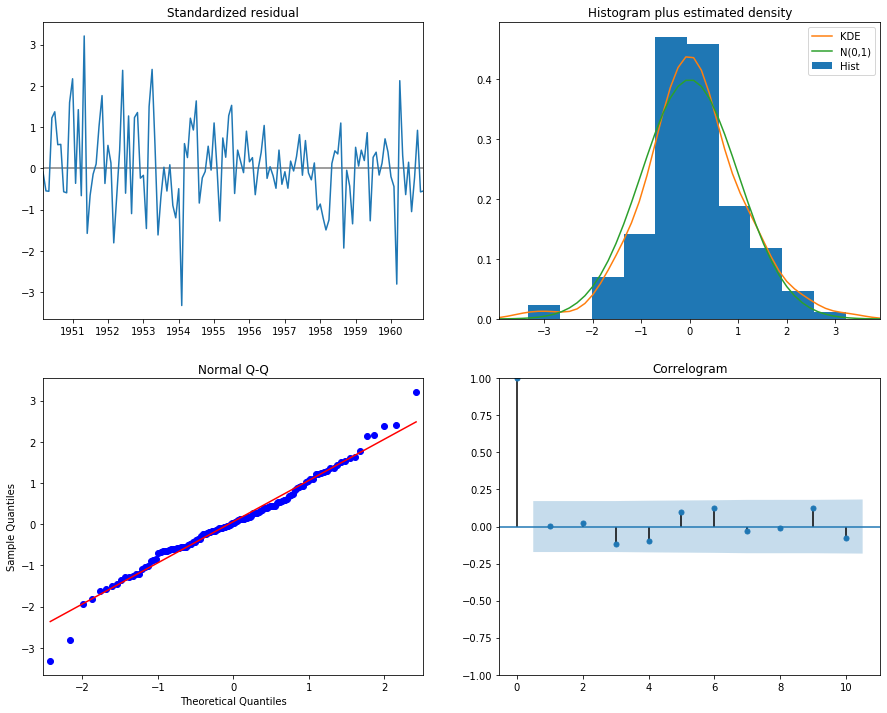

In [35]:
results.plot_diagnostics(figsize=(15, 12))    #Generate model diagnostics and investigate for any unusual behavior.
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

1.In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed. 2.The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed. 3.The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

### 3. Validating Forecasts

In [36]:
#Obtain values for forecasts of the time series from 1958
pred = results.get_prediction(start = pd.to_datetime('1958-01-01'), dynamic = False)
#Obtain associated confidence intervals for forecasts of the time series
pred_ci = pred.conf_int()
pred_ci.head()

,lower #Passengers,upper #Passengers
1958-01-01,5.789096,5.931724
1958-02-01,5.734892,5.877520
1958-03-01,5.874632,6.017256
1958-04-01,5.826375,5.968999
1958-05-01,5.818793,5.961417


Note: The dynamic = False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

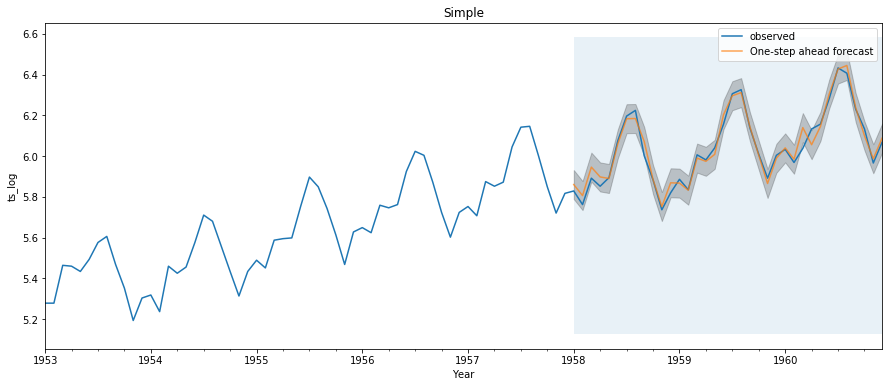

In [37]:
#Plot the forecasted values with historical data
ax = ts_log['1953':].plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'One-step ahead forecast', alpha = 0.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = 'k', alpha = .2)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1958-01-01'), ts_log.index[-1], alpha = .1, zorder = -1)
plt.xlabel('Year')
plt.ylabel('ts_log')
plt.title('Simple')
plt.legend()

In [38]:
pred.predicted_mean.head()

1958-01-01    5.860410
1958-02-01    5.806206
1958-03-01    5.945944
1958-04-01    5.897687
1958-05-01    5.890105
Freq: MS, dtype: float64

In [39]:
ts_log_forecasted = pred.predicted_mean     #From 1958 to 1960 (validation process)
ts_log_original = ts_log['1958-01-01':]
mse = ((ts_log_forecasted - ts_log_original) ** 2).mean()  #Mean square error
print('Mean Squared Error of forecast : {}'.format(round(mse,3)))

Mean Squared Error of forecast : 0.001


Mean square error is almost zero. This means our prediction is very accurate.

However, a better representation of our true predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points. Let's try with computing the dynamic forecast.

In [40]:
pred_dynamic = results.get_prediction(start = pd.to_datetime('1958-01-01'), dynamic = True, full_results = True)
pred_dynamic_ci = pred_dynamic.conf_int()
pred_dynamic_ci.head()

,lower #Passengers,upper #Passengers
1958-01-01,5.789096,5.931724
1958-02-01,5.742086,5.905663
1958-03-01,5.897315,6.077449
1958-04-01,5.870390,6.064032
1958-05-01,5.878692,6.083573


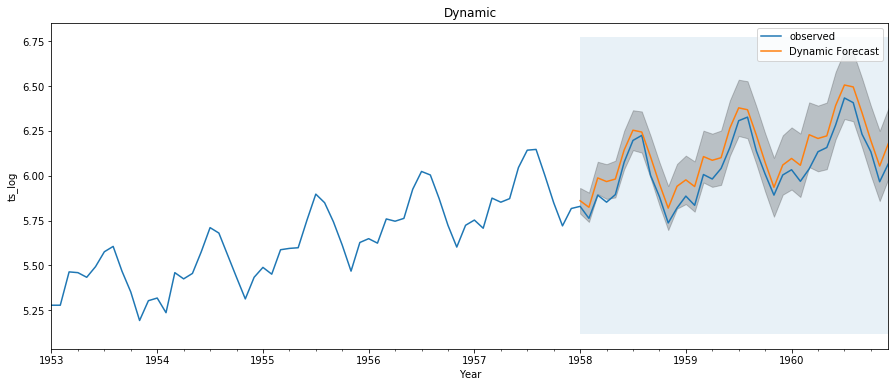

In [41]:
ax = ts_log['1953':].plot(label = 'observed')
pred_dynamic.predicted_mean.plot(ax = ax, label = 'Dynamic Forecast')
ax.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color = 'k', alpha = .2)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1958-01-01'), ts_log.index[-1], alpha = .1, zorder = -1)
plt.xlabel('Year')
plt.ylabel('ts_log')
plt.title('Dynamic')
plt.legend()

In [42]:
ts_log_forecasted_dyna = pred_dynamic.predicted_mean
ts_log_truevalue = ts_log['1958-01-01':]
mse = ((ts_log_forecasted_dyna - ts_log_truevalue) ** 2).mean()
print('Mean Squared Error of forecast : {}'.format(round(mse, 3)))

Mean Squared Error of forecast : 0.008


The predicted values obtained from the dynamic forecasts yield an MSE of .008. This is slightly higher than the one-step ahead, which is to be expected given that we are relying on less historical data from the time series.

Both the one-step ahead and dynamic forecasts confirm that this time series model is valid. However, much of the interest around time series forecasting is the ability to forecast future values way ahead in time.

### 4. Producing and Visualizing Forecasts

In [43]:
pred_uc = results.get_forecast(steps=100)     #Get forecast 100 steps ahead in future (ts_log)
pred_ci = pred_uc.conf_int()                  #Get confidence intervals of forecasts (ts_log)
pred_ci.head()

,lower #Passengers,upper #Passengers
1961-01-01,6.045087,6.187709
1961-02-01,5.978741,6.142312
1961-03-01,6.097809,6.277936
1961-04-01,6.119977,6.313613
1961-05-01,6.151024,6.355900


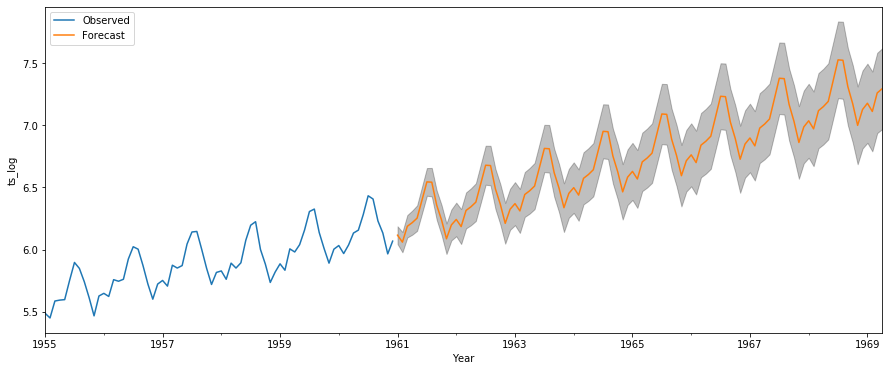

In [44]:
ax = ts_log['1955':].plot(label='Observed')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('ts_log')
plt.legend(loc = 'upper left')
plt.show()

## Back to original data

In [45]:
#Take exponential function
pred_uc = np.exp(pred_uc.predicted_mean)
pred_ci = np.exp(pred_ci)

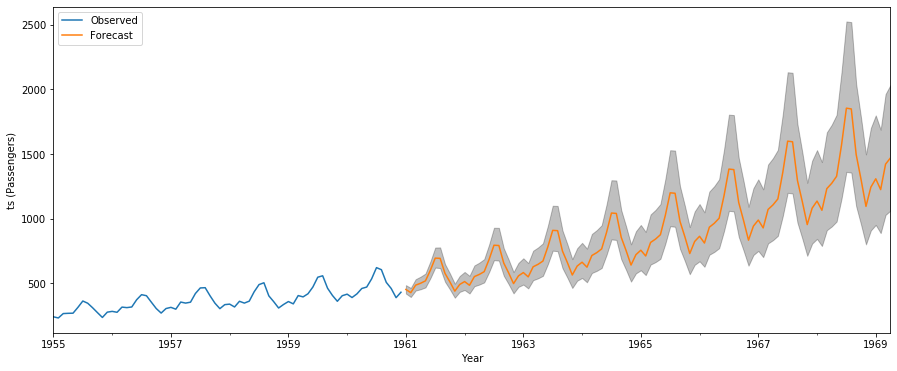

In [46]:
#Plot original data prediction
ax = ts['1955':].plot(label='Observed')
pred_uc.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('ts (Passengers)')
plt.legend(loc = 'upper left')
plt.show()

## References:
 1. Time Series Analysis in Python with statsmodels - Wes McKinney, Josey Perktold, Skipper Seabold
 2. Analytics Vidhya article on Time Series Forecasting.
 3. DigitalOcean article on Time Series Forecasting.

Any suggetion or feedback is heartily welcomed. Also, if you liked my work, please UPVOTE the kernel. Thank you!